## **Load bioactivity data**

dependencies: use conda install -c conda-forge numpy scipy rdkit pandas -y

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/acetylcholinesterase_03_bioactivity_data_curated.csv')
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
6637,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,46000.0,inactive
6638,CHEMBL11298,N[C@@H](CO)C(=O)O,38310.0,inactive
6639,CHEMBL5395312,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,1710.0,intermediate
6640,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,10000.0,inactive


In [3]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [4]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [5]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
6637,CHEMBL5398421,46000.0,inactive,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2
6638,CHEMBL11298,38310.0,inactive,N[C@@H](CO)C(=O)O
6639,CHEMBL5395312,1710.0,intermediate,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...
6640,CHEMBL5399112,10000.0,inactive,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...


## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

### **Import libraries**

In [6]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [10]:
def lipinski(smiles_list, verbose=False):
    """
    Calculate Lipinski descriptors (MW, LogP, H donors, H acceptors)
    for a list of SMILES strings.

    Parameters:
    - smiles_list: iterable of SMILES strings
    - verbose: bool, if True prints warnings and descriptor values

    Returns:
    - pandas.DataFrame with columns ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    """
    data = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)

        # Compute descriptors
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        donors = Lipinski.NumHDonors(mol)
        acceptors = Lipinski.NumHAcceptors(mol)

        data.append([mw, logp, donors, acceptors])

    # Build DataFrame
    columns = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data, columns=columns)
    return descriptors

In [11]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0,6
1,376.913,4.5546,0,5
2,426.851,5.3574,0,5
3,404.845,4.7069,0,5
4,346.334,3.0953,0,6
...,...,...,...,...
6637,301.298,2.0110,4,6
6638,105.093,-1.6094,3,3
6639,401.474,2.9571,3,5
6640,387.447,2.6149,4,5


### **Combine DataFrames**


In [12]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [13]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.8032,0,6
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.5546,0,5
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.3574,0,5
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.7069,0,5
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.0953,0,6
...,...,...,...,...,...,...,...,...
6637,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,46000.0,inactive,301.298,2.0110,4,6
6638,CHEMBL11298,N[C@@H](CO)C(=O)O,38310.0,inactive,105.093,-1.6094,3,3
6639,CHEMBL5395312,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,1710.0,intermediate,401.474,2.9571,3,5
6640,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,10000.0,inactive,387.447,2.6149,4,5


### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [15]:
def pIC50(df):
    """
    Convert IC₅₀ values (in nM) in the ‘standard_value_norm’ column
    to pIC₅₀ (−log10[M]) and drop the original column.
    """
    df = df.copy()
    # Drop rows where standard_value_norm ≤ 0
    mask = df['standard_value_norm'] > 0
    if not mask.all():
        n_bad = (~mask).sum()
    df = df.loc[mask]
    
    df['pIC50'] = -np.log10(df['standard_value_norm'] * 1e-9)
    return df.drop(columns=['standard_value_norm'])

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [16]:
df_combined.standard_value.describe()

count    6.642000e+03
mean     1.026835e+05
std      8.884597e+05
min      0.000000e+00
25%      1.592500e+02
50%      2.600000e+03
75%      1.713000e+04
max      4.960000e+07
Name: standard_value, dtype: float64

In [17]:
def norm_value(df):
    """
    Clamp values in the ‘standard_value’ column to a maximum of 1e8,
    store them in ‘standard_value_norm’, then drop the original column.
    """
    # Make a copy if you don’t want to modify in‑place
    df = df.copy()
    
    # Vectorized clamp (clip) instead of manual loop
    df['standard_value_norm'] = df['standard_value'].clip(upper=1e8)
    
    # Drop the original column by name
    df = df.drop(columns=['standard_value'])
    
    return df


We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [18]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0,6,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0,5,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0,5,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0,5,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0,6,800.0
...,...,...,...,...,...,...,...,...
6637,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,inactive,301.298,2.0110,4,6,46000.0
6638,CHEMBL11298,N[C@@H](CO)C(=O)O,inactive,105.093,-1.6094,3,3,38310.0
6639,CHEMBL5395312,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,intermediate,401.474,2.9571,3,5,1710.0
6640,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,inactive,387.447,2.6149,4,5,10000.0


In [19]:
df_norm.standard_value_norm.describe()

count    6.642000e+03
mean     1.026835e+05
std      8.884597e+05
min      0.000000e+00
25%      1.592500e+02
50%      2.600000e+03
75%      1.713000e+04
max      4.960000e+07
Name: standard_value_norm, dtype: float64

In [20]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0,6,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0,5,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0,5,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0,5,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0,6,6.096910
...,...,...,...,...,...,...,...,...
6637,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,inactive,301.298,2.0110,4,6,4.337242
6638,CHEMBL11298,N[C@@H](CO)C(=O)O,inactive,105.093,-1.6094,3,3,4.416688
6639,CHEMBL5395312,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,intermediate,401.474,2.9571,3,5,5.767004
6640,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,inactive,387.447,2.6149,4,5,5.000000


In [59]:
df_final.pIC50.describe()

count    6641.000000
mean        5.801767
std         1.558782
min         1.304518
25%         4.765989
50%         5.585027
75%         6.795880
max        14.301030
Name: pIC50, dtype: float64

Let's write this to CSV file.

In [ ]:
df_final.to_csv('data/acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')

### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [22]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0,6,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0,5,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0,5,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0,5,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0,6,6.096910
...,...,...,...,...,...,...,...,...
6636,CHEMBL5435795,O=Cc1ccc2n1CCc1cc(O)c(O)cc1C2,inactive,243.262,1.8587,2,4,4.233810
6637,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,inactive,301.298,2.0110,4,6,4.337242
6638,CHEMBL11298,N[C@@H](CO)C(=O)O,inactive,105.093,-1.6094,3,3,4.416688
6640,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,inactive,387.447,2.6149,4,5,5.000000


Let's write this to CSV file.

In [ ]:
df_2class.to_csv('data/acetylcholinesterase_05_bioactivity_data_2class_pIC50.csv')

---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [24]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

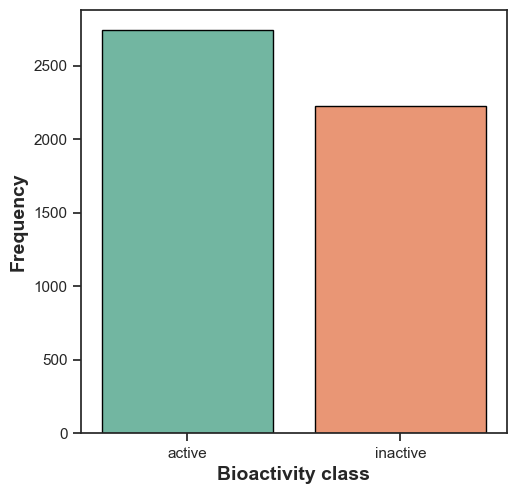

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, palette='Set2', hue = 'class', edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('results/plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

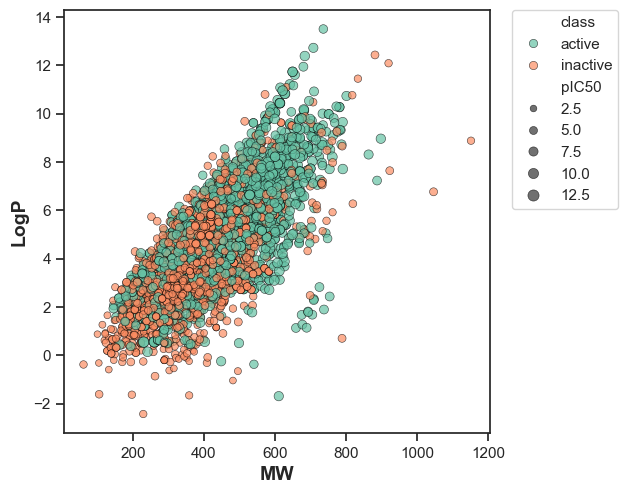

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, palette='Set2', hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('results/plot_MW_vs_LogP.pdf')

### **Box plots**

#### **pIC50 value**

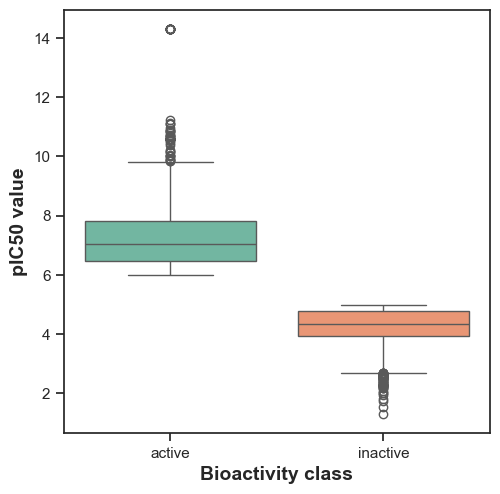

In [27]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', palette='Set2', hue = 'class', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [39]:

def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df["class"] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df["class"] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject null hypothesis)'
  else:
    interpretation = 'Different distribution (reject null hypothesis)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results


In [40]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,6103175.0,0.0,0.05,Different distribution (reject null hypothesis)


#### **MW**

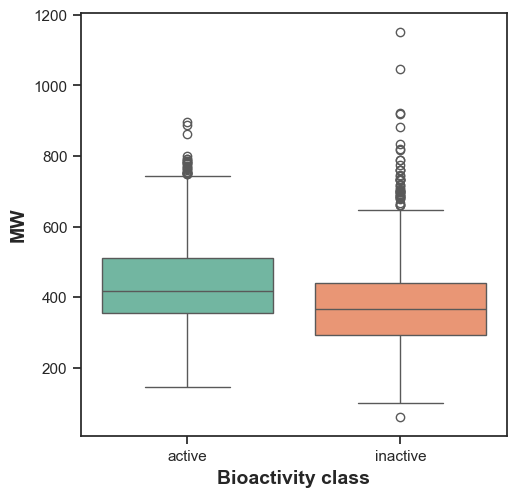

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', palette='Set2', hue = 'class', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('results/plot_MW.pdf')

In [42]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,3960738.0,4.198649e-73,0.05,Different distribution (reject null hypothesis)


#### **LogP**

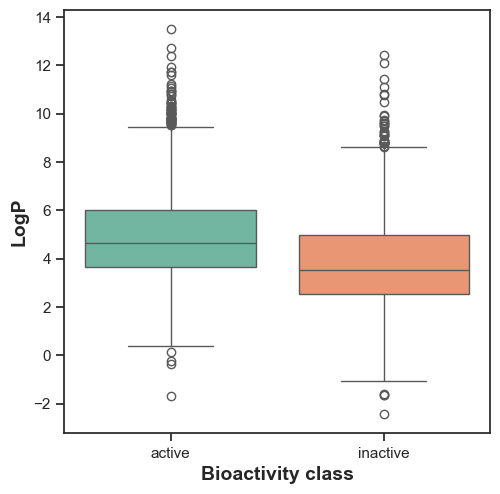

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', palette='Set2', hue = 'class', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('results/plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [45]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,4060495.5,1.372563e-89,0.05,Different distribution (reject null hypothesis)


#### **NumHDonors**

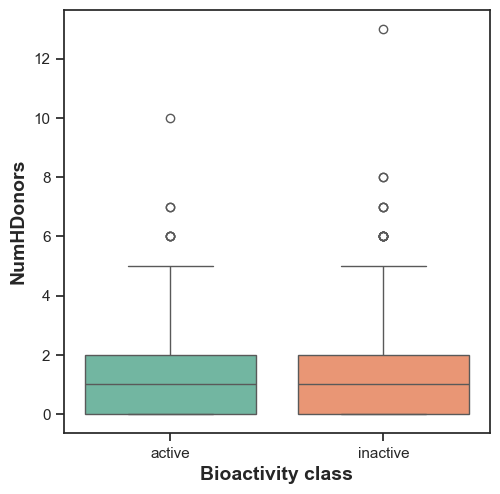

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', palette='Set2', hue = 'class', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('results/plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('results/NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,3451088.5,7.243896e-17,0.05,Different distribution (reject null hypothesis)


#### **NumHAcceptors**

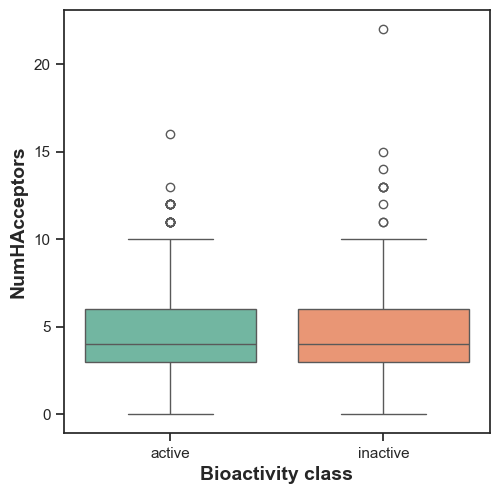

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', palette='Set2', hue = 'class', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('results/plot_NumHAcceptors.pdf')

In [50]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,3283588.5,0.000003,0.05,Different distribution (reject null hypothesis)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

All of the 4 Lipinski's descriptors exhibited ***statistically significant difference*** between the **actives** and **inactives**.